In [2]:
import pandas as pd
import torch
from typing import NamedTuple, Dict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from histaug.extract_features import load_features, LoadedFeatures
from histaug.metrics import compute_dists, SIMILARITY_METRICS
from histaug.feature_extractors import FEATURE_EXTRACTORS

In [8]:
models = FEATURE_EXTRACTORS.keys()
models = ["ctranspath", "swin", "resnet50"]
models = ["ctranspath", "swin"]

features_by_model = {model: load_features(f"/data/histaug/results/kather100k_{model}.zarr") for model in tqdm(models)}

100%|██████████| 2/2 [01:04<00:00, 32.06s/it]


In [21]:
metric = "cosine"
# metric = "euclidean"
# metric = "manhattan"


class LoadedFeaturesAndDists(NamedTuple):
    feats: np.ndarray
    feats_augs: Dict[str, np.ndarray]
    labels: np.ndarray
    files: np.ndarray
    dists: pd.DataFrame


features_and_dists_by_model = {
    model: LoadedFeaturesAndDists(
        feats=f.feats, feats_augs=f.feats_augs, labels=f.labels, files=f.files, dists=compute_dists(f, metric=metric)
    )
    for model, f in tqdm(features_by_model.items())
}

100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


In [22]:
mean_dist_by_class_by_model = {
    model: feats.dists[(feats.labels != "BACK") & (feats.dists["Macenko"] != 1.0)].mean()
    for model, feats in features_and_dists_by_model.items()
}

In [23]:
def compute_baseline_similarity(feats: torch.Tensor, metric: str) -> float:
    """Compute similarity between features and randomly permuted features."""
    feats_perm = feats[torch.randperm(feats.shape[0])]
    return SIMILARITY_METRICS[metric](feats, feats_perm).mean().item()


baseline_similarity_by_model = {
    model: compute_baseline_similarity(torch.from_numpy(f.feats), metric=metric)
    for model, f in features_by_model.items()
}
baseline_similarity_by_model

{'ctranspath': 0.5200650095939636, 'swin': 0.28289395570755005}

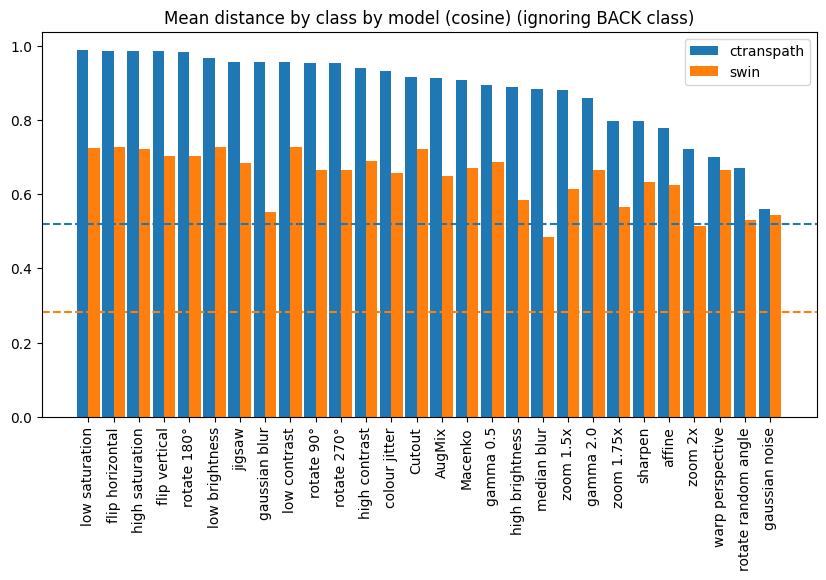

In [24]:
df = pd.DataFrame(mean_dist_by_class_by_model).sort_values(by="ctranspath", ascending=False)

plt.figure(figsize=(10, 5))
plt.title(f"Mean distance by class by model ({metric}) (ignoring BACK class)")

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(df.columns)}

# Grouped bar chart
w = 0.8 / len(df.columns)
for i, (model, d) in enumerate(df.items()):
    b = plt.bar(x=np.arange(len(d)) + i * w, height=d, width=w, label=model, color=model_colors[model])

# Show baseline similarity as horizontal lines
for model, baseline_similarity in baseline_similarity_by_model.items():
    plt.axhline(baseline_similarity, linestyle="--", color=model_colors[model])

plt.xticks(np.arange(len(d)) + w / 2, d.index, rotation=90)

plt.legend(loc="upper right")